# Matrix Factorization (MF) part 2: Getting Fancy
Demonstrates matrix factorization with MXNet on the [MovieLens 100k](http://grouplens.org/datasets/movielens/100k/) dataset.  This is an extension of [part 1](demo1-MF.ipynb) where we try fancy optimizers and network structures.

You need to have python package pandas and bokeh installed (pip install pandas bokeh).

In [1]:
import mxnet as mx
from movielens_data import get_data_iter, max_id
from matrix_fact import train

In [2]:
# If MXNet is not compiled with GPU support (e.g. on OSX), set to [mx.cpu(0)]
# Can be changed to [mx.gpu(0), mx.gpu(1), ..., mx.gpu(N-1)] if there are N GPUs
ctx = [mx.gpu(0)]

In [3]:
train_test_data = get_data_iter(batch_size=100)
max_user, max_item = max_id('./ml-100k/u.data')
(max_user, max_item)

C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:96: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:675: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:670: DeprecationWarning: PlainTextFormatter._type_printers_default is deprecated

(944, 1683)

## Linear MF
Same as before, but this time with the [Adam optimizer](https://arxiv.org/abs/1412.6980) which will often converge much faster than SGD w/ momentum as we used before.  You should see this model over-fitting quickly. 

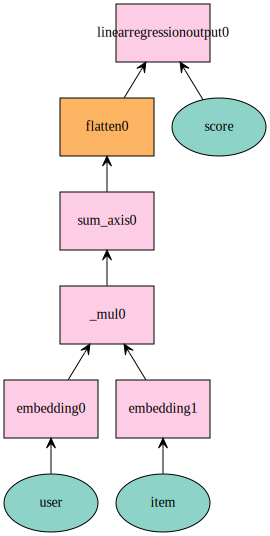

In [4]:
def plain_net(k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user feature lookup
    user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k) 
    # item feature lookup
    item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    # predict by the inner product, which is elementwise product and then sum
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred

net1 = plain_net(64)
mx.viz.plot_network(net1)

In [5]:
results1 = train(net1, train_test_data, num_epoch=25, learning_rate=0.001, optimizer='adam', ctx=ctx)

matrix_fact.py:34: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **opt_args


BokehJS successfully loaded.

AttributeError: unexpected attribute 'visible' to GlyphRenderer, possible attributes are data_source, glyph, hover_glyph, level, name, nonselection_glyph, selection_glyph, tags, x_range_name or y_range_name

## Neural Network (non-linear) MF
The non-linear model converges strangely with Adam.

In [ ]:
def get_one_layer_mlp(hidden, k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user latent features
    user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    # item latent features
    item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.FullyConnected(data = item, num_hidden = hidden)
    # predict by the inner product
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred

net2 = get_one_layer_mlp(64, 64)
mx.viz.plot_network(net2)

In [ ]:
results2 = train(net2, train_test_data, num_epoch=20, learning_rate=0.001, optimizer='adam', ctx=ctx)

## Deep Neural Network (Residual Network / ResNet)
Borrowing ideas from [Deep Residual Learning for Image Recognition (He, et al.)](https://arxiv.org/abs/1512.03385) to build a complex deep network that is aggressively regularized to avoid over-fitting, but still achieves good performance. 

In [ ]:
def get_multi_layer_dropout_resnet(hidden, k):
    # input
    user = mx.symbol.Variable('user')
    item = mx.symbol.Variable('item')
    score = mx.symbol.Variable('score')
    # user latent features
    user1 = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)
    user = mx.symbol.FullyConnected(data = user1, num_hidden = hidden)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.Dropout(data=user, p=0.5)
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    user2 = user + user1
    user2 = mx.symbol.Dropout(data=user2, p=0.5)
    user = mx.symbol.FullyConnected(data = user2, num_hidden = hidden)
    user = mx.symbol.Activation(data = user, act_type='relu')
    user = mx.symbol.Dropout(data=user, p=0.5)
    user = mx.symbol.FullyConnected(data = user, num_hidden = hidden)
    user = user + user2
    # item latent features
    item1 = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)
    item = mx.symbol.FullyConnected(data = item1, num_hidden = hidden)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.Dropout(data=item, p=0.5)    
    item = mx.symbol.FullyConnected(data=item, num_hidden = hidden)
    item2 = item + item1
    item2 = mx.symbol.Dropout(data=item2, p=0.5)    
    item = mx.symbol.FullyConnected(data = item2, num_hidden = hidden)
    item = mx.symbol.Activation(data = item, act_type='relu')
    item = mx.symbol.Dropout(data=item, p=0.5)    
    item = mx.symbol.FullyConnected(data=item, num_hidden = hidden)
    item = item + item2
    # predict by the inner product
    pred = user * item
    pred = mx.symbol.sum_axis(data = pred, axis = 1)
    pred = mx.symbol.Flatten(data = pred)
    # loss layer
    pred = mx.symbol.LinearRegressionOutput(data = pred, label = score)
    return pred
net3 = get_multi_layer_dropout_resnet(64, 64)
mx.viz.plot_network(net3)

In [ ]:
# Larger batch size makes GPU more efficient for this complex model
train_test_data2 = get_data_iter(batch_size=200) 
results3 = train(net3, train_test_data2, num_epoch=25, learning_rate=0.001, optimizer='adam', ctx=ctx)

## Visualizing results
Compare accuracy and training time across the models.

In [ ]:
import bokeh
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import pandas as pd

def viz_lines(fig, results, legend, color):
    df = pd.DataFrame(results._data['eval'])
    fig.line(df.elapsed,df.RMSE, color=color, legend=legend, line_width=2)
    df = pd.DataFrame(results._data['train'])
    fig.line(df.elapsed,df.RMSE, color=color, line_dash='dotted', alpha=0.1)

fig = bokeh.plotting.Figure(x_axis_type='datetime', x_axis_label='Training time', y_axis_label='RMSE')
viz_lines(fig, results1, "Linear MF", "orange")
viz_lines(fig, results2, "MLP", "blue")
viz_lines(fig, results3, "ResNet", "red")

bokeh.io.show(fig)